In [1]:
COLAB = False

import os
import sys

dataset = "flickr30k"

if COLAB:
    
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "CIS583/Project/"
    assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    print(os.listdir(GOOGLE_DRIVE_PATH))
    print(GOOGLE_DRIVE_PATH)

    sys.path.append(GOOGLE_DRIVE_PATH)
    print(sys.path)

    # Define the dataset directory
    dataset_root_dir = os.path.join(GOOGLE_DRIVE_PATH, dataset)
    captions_file_path = os.path.join(dataset_root_dir, "cleaned_captions.txt")

else:

    dataset_root_dir = os.path.join(os.getcwd(), dataset)
    captions_file_path = os.path.join(dataset_root_dir, "cleaned_captions.txt")

In [2]:
import warnings
warnings.filterwarnings('ignore')

# from data import flickr_dataset
# from transformers import CLIPTokenizer
# from torchvision import transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# import PIL as Image
# import random
# import os
# import torch

# # define transforms for dataset
# image_transforms = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# # define CLIP tokenizer
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# dataset = flickr_dataset.FlickrDataset(dataset_root_dir, captions_file_path, image_transforms, tokenizer)
# print(len(dataset))
# dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

# # display dataset example
# image, caption = dataset[random.randint(0, len(dataset))]
# print(tokenizer.decode(caption, skip_special_tokens=True))
# plt.imshow(image.permute(1, 2, 0))
# plt.show()

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

def encode_text(captions):
    # tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
    # embeddings = text_encoder(**tokens).last_hidden_state
    # return embeddings.mean(dim=1)  # Aggregate embeddings
    inputs = tokenizer(captions, return_tensors="pt", padding=True)
    return text_encoder(**inputs).last_hidden_state

## Test on MNIST dataset

In [2]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

n = 10000
batch_size = 128

train_dataset_full = datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
train_dataset = Subset(train_dataset_full, indices=range(n))
print(len(train_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# for batch_idx, (image, caption) in enumerate(train_loader):
#     print("Caption: {}".format(caption))
    
#     fig, axes = plt.subplots(2, 5)
#     for i, ax in enumerate(axes.flat):
#         image_np = image[i].cpu().permute(1, 2, 0).detach().numpy()
#         image_np = (image_np * 255).astype(np.uint8)
#         ax.imshow(image_np)
#         ax.set_title(f'Caption: {caption[i]}')
#         ax.axis('on')
    
#     plt.show()
    

10000


## Modify UNet to return attention maps

In [6]:
from diffusers import UNet2DConditionModel


class UNetWithAttentionMaps(UNet2DConditionModel):
    def __init__(
        self,
        sample_size,
        in_channels,
        out_channels,
        cross_attention_dim,
        attention_head_dim,
        down_block_types,
        up_block_types,
        block_out_channels,
        **kwargs
    ):
        super().__init__(
            sample_size=sample_size,
            in_channels=in_channels,
            out_channels=out_channels,
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=attention_head_dim,
            down_block_types=down_block_types,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            **kwargs
        )
        self.attention_maps = []  # Placeholder to store attention maps

    def _register_attention_hooks(self):
        """
        Register hooks on all attention modules to extract their outputs.
        """
        # def hook_fn(module, input, output):
        #     if hasattr(output, "attention_probs"):
        #         print("Attention map captured!")
        #         self.attention_maps.append(output.attention_probs.detach().cpu())
        
        def hook_fn(module, input, output):
            # Capture attention maps from the module
            if isinstance(output, tuple):
                self.attention_maps.append(output[1])
            else:
                self.attention_maps.append(output)

        # Attach hooks to all attention layers
        # for block in self.down_blocks + self.up_blocks + [self.mid_block]:
        for name, module in self.named_modules():
            if hasattr(module, "attn1") and hasattr(module, "attn2"):
                module.attn1.register_forward_hook(hook_fn)
                module.attn2.register_forward_hook(hook_fn)

    def forward(self, sample, timestep, encoder_hidden_states, return_attention_maps=True, **kwargs):
        """
        Forward pass for the modified UNet to optionally return attention maps.
        """
        if return_attention_maps:
            self.attention_maps = []  # Reset attention maps
            self._register_attention_hooks()
        
        output = super().forward(
            sample=sample,
            timestep=timestep,
            encoder_hidden_states=encoder_hidden_states,
            **kwargs
        )
        
        if return_attention_maps:
            return output, self.attention_maps
        
        print(f"Number of attention maps captured: {len(self.attention_maps)}")
        
        return output


/Users/yashdave/Documents/MSc/CIS583/Project/CIS583/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yashdave/Documents/MSc/CIS583/Project/CIS583/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


19
(28, 28)


/var/folders/gc/kz__mt8x4_5dt3kw4bq0vxm80000gn/T/ipykernel_97494/1590605196.py:74: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


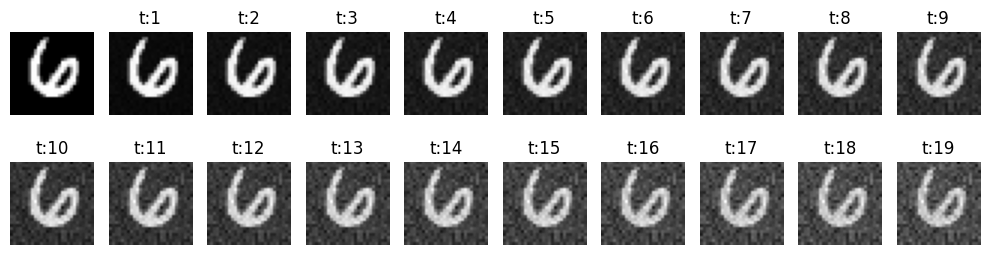

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from models import autoencoder, diffusion
from models import unet
from tqdm import tqdm
import numpy as np
from diffusers import UNet2DConditionModel, DDPMScheduler, UNet2DModel

# Parameters
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # for mac gpu

latent_dim = 32
text_embed_dim = 512
epochs = 10
learning_rate = 1e-4
max_timesteps = 20
save_dir = "checkpoints"
debug_save_dir = "debug_data"

# Create directories
os.makedirs(save_dir, exist_ok=True)
os.makedirs(debug_save_dir, exist_ok=True)

# Models
encoder = autoencoder.Encoder(latent_dim).to(device)
decoder = autoencoder.Decoder(latent_dim).to(device)
# unet = unet.UNet(latent_dim, text_embed_dim).to(device)
# unet = UNet2DConditionModel(
# # unet = UNetWithAttentionMaps(
#     sample_size=28,
#     in_channels=latent_dim,
#     out_channels=latent_dim,
#     cross_attention_dim=text_embed_dim,
#     attention_head_dim=4,
#     down_block_types=("DownBlock2D", "CrossAttnDownBlock2D"),
#     up_block_types=("CrossAttnUpBlock2D", "UpBlock2D"),
#     block_out_channels=(64, 128)
# ).to(device)
unet = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    # down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    # up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
    # block_out_channels=(32, 64, 128)
).to(device)
# print(unet)
# diffusion = diffusion.Diffusion(noise_schedule=torch.linspace(0.01, 0.1, 1000), device=device).to(device)
diffusion = DDPMScheduler(num_train_timesteps=max_timesteps, beta_start=0.0001, beta_end=0.02, beta_schedule="linear")

# Visualizing diffusion process
images, captions = next(iter(train_loader))
image = images[0]
image_shape = image.shape
timesteps = torch.arange(1, max_timesteps)
noise = torch.randn(image_shape)
noisy_images = diffusion.add_noise(image, noise, timesteps).numpy()
print(len(noisy_images))
print(noisy_images[0].shape)

fig, axes = plt.subplots(2, int(len(noisy_images)/2)+1, figsize=(10,10), constrained_layout=True)
axes = axes.ravel()
axes[0].imshow(image[0], cmap='gray')
axes[0].axis('off')
for i, img in enumerate(noisy_images):
    axes[i+1].imshow(img, cmap='gray')
    axes[i+1].set_title(f"t:{i+1}")
    axes[i+1].axis('off')
plt.tight_layout()
plt.tight_layout(h_pad=-15)
plt.show()

# To train from previous checkpoint
# checkpoint = torch.load(os.path.join(save_dir, "mnist_model_epoch_10.pth"))
# encoder.load_state_dict(checkpoint['encoder'])
# decoder.load_state_dict(checkpoint['decoder'])
# unet.load_state_dict(checkpoint['unet'])

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=learning_rate)

## Lattent Space visualization

/var/folders/gc/kz__mt8x4_5dt3kw4bq0vxm80000gn/T/ipykernel_97494/32613840.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


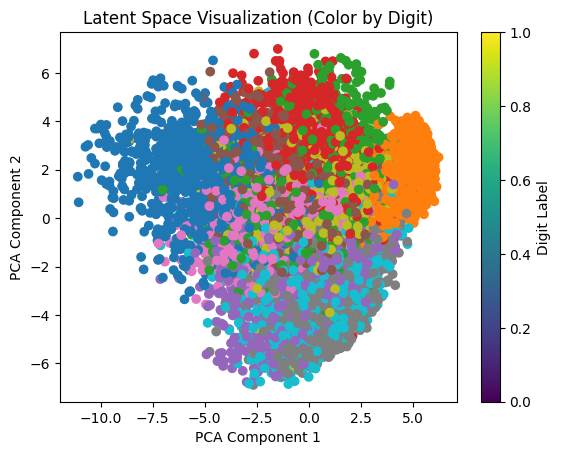

In [5]:
# Visualize latent space
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

temp_data = torch.utils.data.DataLoader(train_dataset_full, batch_size=10000, shuffle=True)

# Encode sample images from the dataset
images, captions = next(iter(temp_data))
images = images.to(device)
latents = encoder(images).detach().cpu().numpy()

# Flatten latents and apply PCA
latents_flat = latents.reshape(latents.shape[0], -1)
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents_flat)

# # Scatter plot of latent representations
# plt.scatter(latents_pca[:, 0], latents_pca[:, 1], c=range(len(latents_pca)))
# plt.colorbar(label="Image Index")
# plt.title("Latent Space Visualization")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.show()

digit_labels = [int(caption) for caption in captions]

# Create a colormap
cmap = cm.get_cmap('tab10')

# Assign colors based on digit labels
colors = cmap(digit_labels)

# Scatter plot with color coding
plt.scatter(latents_pca[:, 0], latents_pca[:, 1], c=colors)
plt.colorbar(label="Digit Label")
plt.title("Latent Space Visualization (Color by Digit)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Forward diffusion visualization

Caption: 0


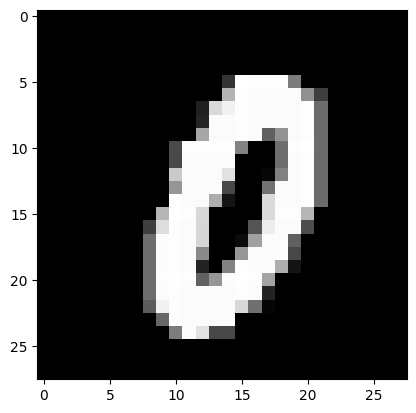

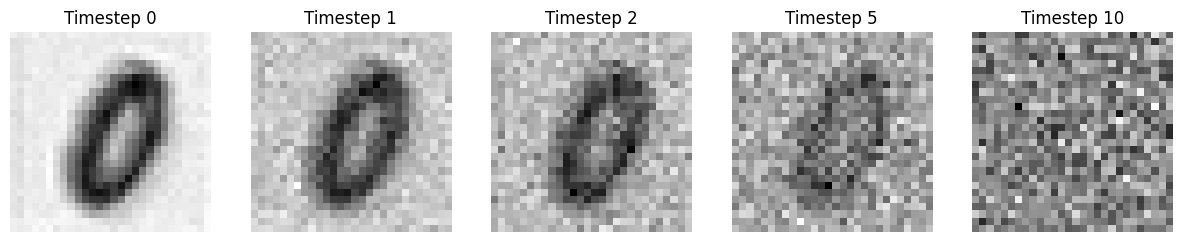

In [10]:
images, captions = next(iter(train_loader))
images = images[:1].to(device)

# Sample image and encode
image = images[0:1]
latent = encoder(image).detach()
print("Caption: {}".format(captions[0]))
plt.imshow(image[0].cpu().permute(1, 2, 0).detach().numpy(), cmap="gray")

# Add noise for different timesteps
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for idx, t in enumerate([0, 1, 2, 5, 10]):
    noise = torch.randn_like(latent)
    noisy_latent = diffusion.add_noise(latent, noise, timesteps=torch.tensor([t]).to(device))
    axes[idx].imshow(noisy_latent[0, 0].cpu(), cmap='gray')
    axes[idx].set_title(f"Timestep {t}")
    axes[idx].axis("off")
plt.show()

## Reverse diffusion visualization

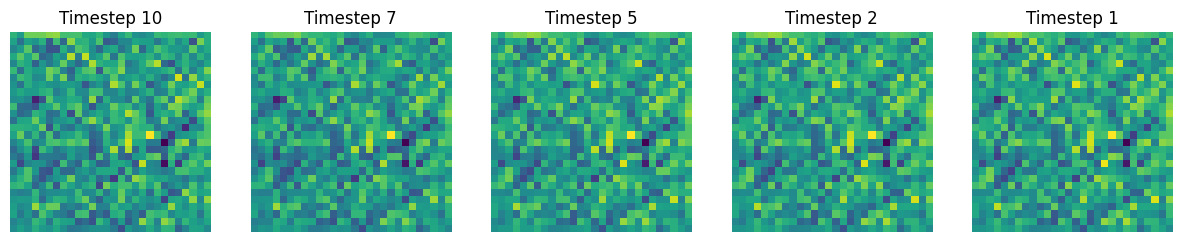

In [13]:
latent_noise = torch.randn((1, latent_dim, 28, 28)).to(device)
text_embedding = encode_text(["1"]).to(device)

# Perform reverse diffusion
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for idx, t in enumerate([10, 7, 5, 2, 1]):
    t_tensor = torch.full((latent_noise.size(0),), t, device=device, dtype=torch.long)
    predicted_noise, _ = unet(latent_noise, t_tensor, encoder_hidden_states=text_embedding)
    scheduler_output = diffusion.step(predicted_noise.sample, t_tensor, latent_noise)
    latent_noise = scheduler_output.prev_sample

    decoded_image = decoder(latent_noise)
    axes[idx].imshow(decoded_image[0].cpu().permute(1, 2, 0).detach().numpy())
    axes[idx].set_title(f"Timestep {t}")
    axes[idx].axis("off")
plt.show()

## Cross attention visualization

456
torch.Size([1, 196, 128])
(196,)
(28, 28, 3)
(28, 28, 1)


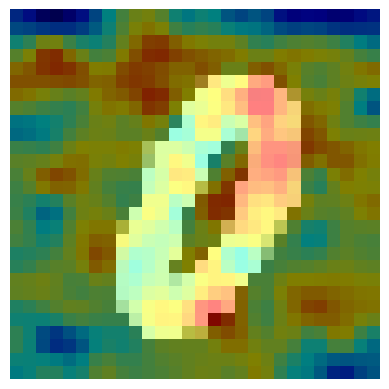

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Modify U-Net to return attention maps
output, attention_maps = unet(latent_noise, t_tensor, encoder_hidden_states=text_embedding)
print(len(attention_maps))
print(attention_maps[0].shape)

def overlay_attention_on_image(image, attention_map, layer_index=0, head_index=0, alpha=0.5, grid_size=None):
    """
    Overlay the attention map on the input image.

    Args:
        image (torch.Tensor): The input image (batch_size, channels, height, width).
        attention_map (torch.Tensor): The attention maps (layers, batch_size, queries, keys).
        layer_index (int): Index of the layer to visualize.
        head_index (int): Index of the attention head to visualize.
        alpha (float): Transparency factor for overlay.
        grid_size (tuple, optional): Specify (height, width) of the attention map grid if not a perfect square.

    Returns:
        image_with_attention (numpy.ndarray): Image with attention overlay.
    """
    if isinstance(attention_map, list):
        attention_map = torch.stack(attention_map, dim=0)

    # Select the attention map for the desired layer and head
    # attention_map = attention_map[layer_index, head_index]  # Shape: (queries, keys)
    attention_map = attention_map[120][0, :, 120]  # Shape: (queries, keys)

    # Normalize for better visualization
    attention_map = attention_map.detach().cpu().numpy()
    attention_map -= attention_map.min()
    attention_map /= attention_map.max()

    # Infer spatial dimensions
    queries = attention_map.shape[0]
    if grid_size is None:
        # Auto-infer grid size (assume square if possible)
        spatial_dim = int(np.sqrt(queries))
        if spatial_dim ** 2 != queries:
            raise ValueError("Specify `grid_size` when attention map is not square.")
        grid_size = (spatial_dim, spatial_dim)

    print(attention_map.shape)

    # Reshape to spatial dimensions (H, W)
    attention_map = attention_map.reshape(grid_size)

    # Resize the attention map to match the input image size (height, width)
    h, w = image.shape[2], image.shape[3]
    attention_map_resized = cv2.resize(attention_map, (w, h))

    # Convert the image tensor to numpy and scale it to 0-255 for visualization
    image = image.detach().cpu().numpy()[0]  # For batch_size=1
    image = np.transpose(image, (1, 2, 0))  # Convert to HWC
    image = np.clip(image * 255, 0, 255).astype(np.uint8)

    # Create a heatmap from the attention map
    attention_map_colored = cv2.applyColorMap((attention_map_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)

    print(attention_map_colored.shape)
    print(image.shape)

    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Overlay the attention map on the image with transparency (alpha)
    image_with_attention = cv2.addWeighted(image_color, 1 - alpha, attention_map_colored, alpha, 0)

    return image_with_attention



# input_image = torch.randn(1, 3, 28, 28).to(device)  # Replace with your input image
# attention_maps = torch.randn(60, 1, 196, 128).to(device)  # Replace with your attention maps

# Call the function to overlay attention
image_with_attention = overlay_attention_on_image(image, attention_maps, layer_index=0, head_index=0, alpha=0.5, grid_size=(14,14))

# Plot the result
plt.imshow(image_with_attention)
plt.axis('off')
plt.show()


# Loop through attention heads (128) and plot each one
# fig, axes = plt.subplots(4, 16, figsize=(16, 4))  # Adjust based on the number of heads

# for i, ax in enumerate(axes.flat):
#     if i < 128:
#         attention_map = attention_maps[i][0, :, i]  # Extract the i-th attention head
#         attention_map = attention_map.detach().cpu().numpy().reshape(14, 14)
#         ax.imshow(attention_map, cmap='viridis')
#         ax.set_title(f"Head {i+1}")
#         ax.axis('off')  # Hide axis

# plt.tight_layout()
# plt.show()



In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

show_image = False
show_latent_distributions = False
save_debug_visualizations = False

# Training Loop
for epoch in range(epochs):
    # encoder.train()
    # decoder.train()
    unet.train()
    total_loss = 0

    # To store latents for debugging
    forward_latent_representations = []
    reverse_latent_representations = []

    for batch_idx, (images, captions) in enumerate(tqdm(train_loader)):
        torch.mps.empty_cache()
        images = images.to(device)
        # Convert captions tensor to a list of strings
        # captions = captions.to(device)
        # captions = [dataset.tokenizer.decode(caption, skip_special_tokens=True) for caption in captions]

        # Encode text
        # print(captions)
        # captions = list(map(str, captions))
        # text_embedding = encode_text(captions).to(device)

        # Encode images
        # latents = encoder(images)

        # latent visualization
        # combined_latent = torch.cat([latent, text_embedding], dim=1)
        # forward_latent_representations.append(latents.detach().cpu().numpy())

        # Forward Diffusion
        # t = torch.randint(0, 1000, (images.size(0),)).to(device)
        # noisy_latent = diffusion.forward_diffusion(latent, t=t)
        # noise = torch.randn_like(latents).to(device)
        # t = torch.randint(0, diffusion.num_train_timesteps, (images.size(0),), device=device).long()
        # noisy_latents = diffusion.add_noise(latents, noise, t)

        

        # print(f"Noisy latents shape: {noisy_latents.shape}")  #[batch_size, latent_dim, 28, 28]
        # print(f"Timesteps shape: {t.shape}")  #[batch_size]
        # print(f"Text embeddings shape: {text_embedding.shape}")  # [batch_size, seq_length, text_embed_dim]

        timesteps = torch.randint(0, max_timesteps,(images.size(0),)).to(device)
        noise = torch.randn(image_shape).to(device)
        noisy_images = diffusion.add_noise(images, noise, timesteps)

        # U-Net prediction
        # predicted_noise, attention_maps = unet(noisy_latents, t, encoder_hidden_states=text_embedding)
        # predicted_noise = predicted_noise.sample

        predicted_noise = unet(noisy_images, timesteps, return_dict=False)[0]

        # Reverse diffusion
        # recovered_latent = diffusion.reverse_diffusion(noisy_latents, t=t, predicted_noise=predicted_noise)

        # latent visualization
        # reverse_latent_representations.append(recovered_latent.detach().cpu().numpy())

        # Decode back to image
        # reconstructed_image = decoder(predicted_noise)

        # if save_debug_visualizations:
            # print(captions[0])
            # image_np = images[0].cpu().permute(1, 2, 0).detach().numpy()
            # image_np = (image_np * 255).astype(np.uint8)
            # recon_image_np = reconstructed_image[0].cpu().permute(1, 2, 0).detach().numpy()
            # recon_image_np = (recon_image_np * 255).astype(np.uint8)
            # plt.imshow(image_np)
            # plt.show()
            # plt.imshow(recon_image_np)
            # plt.show()
            # show_image = False
            # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            # original_image = images[0].cpu().permute(1, 2, 0).numpy()
            # original_image = (original_image * 255).astype(np.uint8)
            # reconstructed_image_np = reconstructed_image[0].cpu().permute(1, 2, 0).detach().numpy()
            # reconstructed_image_np = (reconstructed_image_np * 255).astype(np.uint8)

            # ax[0].imshow(original_image)
            # ax[0].set_title("Original Image")
            # ax[0].axis("off")

            # ax[1].imshow(reconstructed_image_np)
            # ax[1].set_title("Reconstructed Image")
            # ax[1].axis("off")

            # plt.tight_layout()
            # # plt.savefig(os.path.join(debug_save_dir, f"epoch_{epoch+1}_batch_{batch_idx+1}_image.png"))
            # plt.close(fig)

        # Loss
        loss = criterion(predicted_noise, noise)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print("Batch: {}".format(batch_idx))
        # print("Loss for current batch: {}".format(loss))

    # Log progress
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

    if (epoch+1)%epochs == 0:
        # Save checkpoint
        torch.save({
            # 'encoder': encoder.state_dict(),
            # 'decoder': decoder.state_dict(),
            'unet': unet.state_dict()
        }, os.path.join(save_dir, f"mnist_model_epoch_{epoch + 1}.pth"))

print("Training complete!")

  0%|          | 0/79 [00:03<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 7 for tensor number 1 in the list.

In [59]:
import numpy as np

# Load the saved model
save_dir = "checkpoints"
checkpoint = torch.load(os.path.join(save_dir, "mnist_model_epoch_10.pth"))

# Load the state dictionaries into the models
# encoder.load_state_dict(checkpoint['encoder'])
# decoder.load_state_dict(checkpoint['decoder'])
unet.load_state_dict(checkpoint['unet'])

# print(encoder)
# print(decoder)
# print(unet)

# Set the models to evaluation mode
# encoder.eval()
# decoder.eval()
unet.eval()

# def generate_image(caption, num_steps=1000):
#     with torch.no_grad():
#         text_embedding = encode_text([caption]).to(device)
#         latent_noise = torch.randn((1, latent_dim, 28, 28)).to(device)
#         # t = torch.randint(0, 1000, (images.size(0),)).to(device)
#         # latent_noise = diffusion.forward_diffusion(latent, t=t)

#         for step_t in reversed(range(num_steps)):
#             # predicted_noise = unet(latent_noise, text_embedding)
#             # latent_noise = diffusion.reverse_diffusion(latent_noise, t, predicted_noise)
#             latent = diffusion.step(
#             unet(latent_noise, torch.tensor([t]).to(device), encoder_hidden_states=text_embedding).sample, step_t, latent).prev_sample

#         return decoder(latent)

# def generate_image(caption, num_steps=10):
#     with torch.no_grad():
#         # Encode the text
#         text_embedding = encode_text([caption]).to(device)
        
#         # Start from random noise
#         latent_noise = torch.randn((1, latent_dim, 28, 28)).to(device)
        
#         # Generate timesteps for reverse process
#         timesteps = torch.linspace(num_steps - 1, 0, num_steps, device=device, dtype=torch.long)
        
#         # Reverse diffusion process
#         for t in timesteps:
#             t_tensor = torch.full((latent_noise.size(0),), t, device=device, dtype=torch.long)
            
#             # Predict noise using the U-Net
#             predicted_noise, _ = unet(latent_noise, t_tensor, encoder_hidden_states=text_embedding)
#             predicted_noise = predicted_noise.sample
            
#             # Perform one denoising step
#             scheduler_output = diffusion.step(
#                 model_output=predicted_noise,
#                 timestep=t,
#                 sample=latent_noise
#             )
#             latent_noise = scheduler_output.prev_sample

#         # Decode the final latent to get the image
#         generated_image = decoder(latent_noise)
#         return generated_image


# Test
# generated_image = generate_image("2")

target_img_shape = [1, 28,28]
# generator = torch.Generator(device=device).manual_seed(np.random.randint(1,100))
generated_image = torch.randn(size=(1, *target_img_shape)).to(device)

for idx, t in enumerate(timesteps):
    model_out = unet(generated_image, timesteps)
    image_out = diffusion.step(model_out, timesteps, generated_image).prev_sample

# reconstructed_image_np = reconstructed_image[0].cpu().permute(1, 2, 0).detach().numpy()
# reconstructed_image_np = (reconstructed_image_np * 255).astype(np.uint8)

# Convert the tensor to a numpy array
image_np = generated_image[0].cpu().permute(1, 2, 0).detach().numpy()

image_np = (image_np).astype(np.uint8)

# Display the image
plt.imshow(image_np, cmap='gray')
plt.axis('on')
plt.show()


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 104 but got size 1 for tensor number 1 in the list.